# X5

In [1]:
import random

import numpy as np
import pandas as pd

import torch

torch.cuda.empty_cache()

def seed_all(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

In [2]:
SEED = 42
# seed_all(SEED)

In [3]:
# torch.cuda.reset_peak_memory_stats()
# torch.cuda.empty_cache()

In [4]:
from pathlib import Path

DATA_PATH = Path('../../../data/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

DATA_PATH_DOWNLOAD = DATA_PATH / Path('download/')
DATA_PATH_DOWNLOAD.mkdir(parents=True, exist_ok=True)

DATA_PATH_DATASET = DATA_PATH / Path('datasets/')
DATA_PATH_DATASET.mkdir(parents=True, exist_ok=True)

DATA_SYNTHETICS = DATA_PATH / Path('synthetics/')
DATA_PATH_DATASET.mkdir(parents=True, exist_ok=True)

DATA_CACHE = DATA_PATH / Path('cache_dir/')
DATA_CACHE.mkdir(parents=True, exist_ok=True)

DATA_PATH_SAVE_MODELS = DATA_PATH / Path('models/')
DATA_PATH_SAVE_MODELS.mkdir(parents=True, exist_ok=True)

DATA_IMGS = DATA_PATH /  Path('imgs/')
DATA_IMGS.mkdir(parents=True, exist_ok=True)

import pandas as pd

pd.set_option('display.max_colwidth', 500) 

In [5]:
import sys
import os

project_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(project_path)

In [6]:
BASE_MODEL_NAME = 'cointegrated/rubert-tiny2'
# BASE_MODEL_NAME = 'DeepPavlov/distilrubert-small-cased-conversational'
# BASE_MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MODEL_NAME_SAVE = "ner_x5"
MODEL_CHECKPOINT_PATH = "ner_x5_checkpoint"

In [7]:
from datetime import datetime

current_date = datetime.now().strftime("%d-%m-%Y")
DATA_LOG = DATA_PATH / Path(f'../logs/{MODEL_NAME_SAVE}_{current_date}')
DATA_LOG.mkdir(parents=True, exist_ok=True)

In [8]:
MAX_LENGTH = 10
BATCH_SIZE = 128

# Данные

In [9]:
df_x5 = pd.read_csv(DATA_PATH_DATASET / "train.csv", sep=";")

df_x5.sample(5)

,sample,annotation
25128,хлебцы,"[(0, 6, 'B-TYPE')]"
5278,газ roy,"[(0, 3, 'B-TYPE'), (4, 7, 'B-BRAND')]"
23467,то атный сок,"[(0, 2, 'B-TYPE'), (3, 8, 'I-TYPE'), (9, 12, 'I-TYPE')]"
675,econova та,"[(0, 7, 'B-BRAND'), (8, 10, 'B-TYPE')]"
18766,рощмарин,"[(0, 8, 'B-TYPE')]"


In [10]:
def normalize_annotations(ann_list):
    if isinstance(ann_list, str):
        ann_list = eval(ann_list)
    new_list = []
    for start, end, label in ann_list:
        if label == "0":
            label = "O"
        new_list.append((start, end, label))
    return new_list

df_x5["annotation"] = df_x5["annotation"].apply(normalize_annotations)

In [11]:
all_labels = set()

for ann_list in df_x5["annotation"]:
    if isinstance(ann_list, str):
        ann_list = eval(ann_list)
    for _, _, label in ann_list:
        all_labels.add(label)

unique_labels = sorted(all_labels)
unique_labels

['B-BRAND',
 'B-PERCENT',
 'B-TYPE',
 'B-VOLUME',
 'I-BRAND',
 'I-PERCENT',
 'I-TYPE',
 'I-VOLUME',
 'O']

In [12]:
df_x5.sample(5)

,sample,annotation
14070,мячи симба,"[(0, 4, B-TYPE), (5, 10, B-BRAND)]"
3580,блинчики,"[(0, 8, B-TYPE)]"
26792,энернетики,"[(0, 10, B-TYPE)]"
26976,ядоа,"[(0, 4, B-TYPE)]"
13885,мыло дл рук,"[(0, 4, B-TYPE), (5, 7, O), (8, 11, O)]"


In [13]:
df_submission = pd.read_csv(DATA_PATH_DATASET / "submission.csv", sep=";")
df_submission["annotation"] = df_submission["annotation"].apply(normalize_annotations)

In [14]:
import pandas as pd
from pathlib import Path
import ast

def load_synthetic_file(file_path: str | Path) -> pd.DataFrame:
    file_path = Path(file_path)
    data = []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            try:
                text, ann_str = line.split(";", 1)
                text = text.strip()
                annotation = ast.literal_eval(ann_str.strip())
                data.append({"sample": text, "annotation": annotation})
            except Exception as e:
                print(f"Ошибка при обработке строки в {file_path}: {line}\n{e}")

    return pd.DataFrame(data)


In [15]:
def load_synthetic_dataset(data_dir: str | Path) -> pd.DataFrame:
    data_dir = Path(data_dir)
    all_dfs = []

    for file_path in data_dir.glob("*.txt"):
        df_file = load_synthetic_file(file_path)
        all_dfs.append(df_file)

    if all_dfs:
        return pd.concat(all_dfs).reset_index(drop=True)
    else:
        return pd.DataFrame(columns=["sample", "annotation"])


In [16]:
df_synthetic = load_synthetic_dataset(DATA_SYNTHETICS)

Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: молоко простоквашино 3.2% 1 л и хлеб дарницкий 400 г;
invalid syntax (<unknown>, line 0)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: [(0, 6, "B-TYPE"), (7, 19, "B-BRAND"), (20, 24, "B-PERCENT"), (25, 28, "B-VOLUME"), (31, 35, "B-TYPE"), (36, 45, "B-BRAND"), (46, 51, "B-VOLUME")]
not enough values to unpack (expected 2, got 1)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: кефир валио 1% 930 г и сыр президент 45% 200 г;
invalid syntax (<unknown>, line 0)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: [(0, 5, "B-TYPE"), (6, 11, "B-BRAND"), (12, 14, "B-PERCENT"), (15, 20, "B-VOLUME"), (23, 26, "B-TYPE"), (27, 36, "B-BRAND"), (37, 41, "B-PERCENT"), (42, 47, "B-VOLUME")]
not enough values to unpack (expected 2, got 1)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: шоколад милка 90 г и печенье юбилейное 300 г;
invalid syntax (<unknown>, line 0)

In [17]:
df_x5["df_label"] = "x5"
df_synthetic["df_label"] = "synthetic"

dfs = []
dfs.append(df_x5)
dfs.append(df_synthetic)

In [ ]:
df_train = pd.concat(dfs, ignore_index=True)
# df_train = df_train.drop_duplicates(subset=["sample"]).reset_index(drop=True)

In [19]:
df_synthetic.sample(5)

,sample,annotation,df_label
302,shogetten,"[(0, 9, B-BRAND)]",synthetic
2350,корм для котёнка,"[(0, 4, B-TYPE), (5, 9, I-TYPE), (10, 17, I-TYPE)]",synthetic
1150,маска для волос питательная,"[(0, 5, B-TYPE), (6, 9, I-TYPE), (10, 15, I-TYPE), (16, 27, I-TYPE)]",synthetic
407,положи макароны pasta zara 450 г,"[(7, 15, B-TYPE), (16, 25, B-BRAND), (26, 31, B-VOLUME)]",synthetic
1520,хлеб бороднскй нарез,"[(0, 4, B-TYPE), (5, 15, I-TYPE), (16, 22, I-TYPE)]",synthetic


# Словари

In [20]:
unique_labels = {label for anns in df_train["annotation"] for _, _, label in anns if label != "O"}

b_labels = sorted([lbl for lbl in unique_labels if lbl.startswith("B-")])
i_labels = {lbl[2:]: lbl for lbl in unique_labels if lbl.startswith("I-")}

all_labels = ["O"]
for b in b_labels:
    all_labels.append(b)
    base = b[2:]
    if base in i_labels:
        all_labels.append(i_labels[base])

label2idx = {label: idx for idx, label in enumerate(all_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

print("label2idx:", label2idx)
print("idx2label:", idx2label)


label2idx: {'O': 0, 'B-BRAND': 1, 'I-BRAND': 2, 'B-PERCENT': 3, 'I-PERCENT': 4, 'B-TYPE': 5, 'I-TYPE': 6, 'B-VOLUME': 7, 'I-VOLUME': 8}
idx2label: {0: 'O', 1: 'B-BRAND', 2: 'I-BRAND', 3: 'B-PERCENT', 4: 'I-PERCENT', 5: 'B-TYPE', 6: 'I-TYPE', 7: 'B-VOLUME', 8: 'I-VOLUME'}


In [21]:
import json

label2idx_path = DATA_PATH_SAVE_MODELS / "label2idx.json"
idx2label_path = DATA_PATH_SAVE_MODELS / "idx2label.json"

with open(label2idx_path, "w", encoding="utf-8") as f:
    json.dump(label2idx, f, ensure_ascii=False, indent=4)

with open(idx2label_path, "w", encoding="utf-8") as f:
    json.dump(idx2label, f, ensure_ascii=False, indent=4)

print(f"Словарь label2idx сохранён в {label2idx_path}")
print(f"Словарь idx2label сохранён в {idx2label_path}")

Словарь label2idx сохранён в ..\..\..\data\models\label2idx.json
Словарь idx2label сохранён в ..\..\..\data\models\idx2label.json


# Датасет

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data: pd.DataFrame
val_data: pd.DataFrame
train_data, val_data = train_test_split(
    df_train,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)


In [23]:
train_data.head()

,sample,annotation,df_label
29880,майонез⁹,"[(0, 7, B-TYPE)]",synthetic
7573,иаедарины,"[(0, 9, B-TYPE)]",x5
7286,заточные станки,"[(0, 8, B-TYPE), (9, 15, I-TYPE)]",x5
20890,сок j 7,"[(0, 3, B-TYPE), (4, 5, B-BRAND), (6, 7, B-VOLUME)]",x5
5160,волчёк,"[(0, 6, B-TYPE)]",x5


In [24]:
df_submission.head()

,sample,annotation
0,форма для выпечки,"[(0, 5, B-TYPE), (6, 9, I-TYPE), (10, 17, I-TYPE)]"
1,фарш свиной,"[(0, 4, B-TYPE), (5, 11, I-TYPE)]"
2,сок ананасовый без сахара,"[(0, 3, B-TYPE), (4, 14, I-TYPE), (15, 18, I-TYPE), (19, 25, I-TYPE)]"
3,еринги,"[(0, 6, B-TYPE)]"
4,молооко,"[(0, 7, B-TYPE)]"


In [25]:
from ml.dataset import NerDataSet

dtype_input = torch.long
dtype_labels = torch.long

train_dataset = NerDataSet(
    df=train_data, 
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True    
)

val_dataset = NerDataSet(
    df=val_data,
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True
)

test_dataset = NerDataSet(
    df=df_submission, 
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True
)


Tokenizing data: 100%|████████████████████████████████████████| 5000/5000 [00:00<00:00, 8371.63it/s]


In [26]:
import torch
from collections import Counter
import numpy as np

def count_labels(dataset, idx2label):
    all_labels = []
    for labels in dataset.labels.tolist():
        for l in labels:
            if l != -100:
                all_labels.append(l)
    counts = Counter(all_labels)

    label_counts = {idx2label[i]: counts.get(i, 0) for i in range(len(idx2label))}
    return label_counts

label_counts = count_labels(train_dataset, idx2label)
for label, cnt in label_counts.items():
    print(f"{label:15s} : {cnt}")


O               : 62831
B-BRAND         : 7624
I-BRAND         : 10790
B-PERCENT       : 65
I-PERCENT       : 37
B-TYPE          : 24645
I-TYPE          : 43487
B-VOLUME        : 368
I-VOLUME        : 246


In [27]:
test_dataset[0]

{'input_ids': tensor([    2,  9295,   871, 72728,     3,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([   0,    5,    6,    6,    0, -100, -100, -100, -100, -100])}

In [28]:
val_dataset.df.sample(10)

,sample,annotation,df_label,tokens_ids_debug,tokens_text_debug,labels_debug
314,царь пшен,"[(0, 4, B-BRAND), (5, 9, B-TYPE)]",x5,"[2, 40261, 327, 7139, 3, 0, 0, 0, 0, 0]","[[CLS], царь, п, ##шен, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-BRAND, B-TYPE, I-TYPE, O, O, O, O, O, O]"
401,котлеьт,"[(0, 7, B-TYPE)]",x5,"[2, 32182, 1736, 26172, 3, 0, 0, 0, 0, 0]","[[CLS], кот, ##ле, ##ьт, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]"
905,цедра,"[(0, 5, B-TYPE)]",x5,"[2, 3789, 11532, 3, 0, 0, 0, 0, 0, 0]","[[CLS], це, ##дра, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]"
1865,нутрил,"[(0, 6, B-TYPE)]",x5,"[2, 29599, 27779, 869, 3, 0, 0, 0, 0, 0]","[[CLS], ну, ##три, ##л, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]"
413,кусочеи,"[(0, 7, B-TYPE)]",x5,"[2, 30689, 20413, 613, 3, 0, 0, 0, 0, 0]","[[CLS], кус, ##оче, ##и, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]"
1133,тушенки,"[(0, 7, B-TYPE)]",x5,"[2, 11997, 7139, 954, 3, 0, 0, 0, 0, 0]","[[CLS], ту, ##шен, ##ки, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]"
2032,сментана,"[(0, 8, B-TYPE)]",x5,"[2, 42681, 11879, 3, 0, 0, 0, 0, 0, 0]","[[CLS], смен, ##тана, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]"
1434,grange,"[(0, 6, B-BRAND)]",x5,"[2, 1467, 876, 3, 0, 0, 0, 0, 0, 0]","[[CLS], gran, ##ge, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, O, O, O, O, O, O, O]"
1969,горчичный порош,"[(0, 9, B-TYPE), (10, 15, I-TYPE)]",x5,"[2, 83595, 8034, 40839, 3, 0, 0, 0, 0, 0]","[[CLS], горчи, ##чный, порош, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]"
373,базилик тенде,"[(0, 7, B-TYPE), (8, 13, B-BRAND)]",x5,"[2, 26476, 13525, 31299, 3, 0, 0, 0, 0, 0]","[[CLS], бази, ##лик, тенде, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, B-BRAND, O, O, O, O, O, O]"


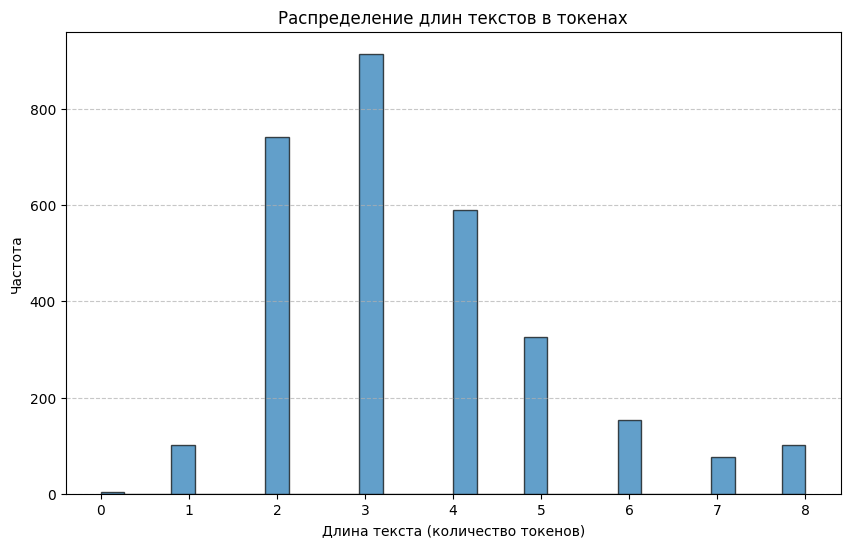

In [29]:
val_dataset.plot_token_length_distribution()

# Модель

In [30]:
num_labels = len(label2idx)

In [31]:
from transformers import AutoConfig
from ml.model import AutoModelForTokenClassificationWithCRF, TokenClassifierCRFOutput

config = AutoConfig.from_pretrained(
    BASE_MODEL_NAME,
    num_labels=num_labels,
    id2label=idx2label,
    label2id=label2idx,
    cache_dir=DATA_CACHE,
)

model = AutoModelForTokenClassificationWithCRF.from_pretrained(
    BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    config=config,
    ignore_mismatched_sizes=True,
)

# # model.gradient_checkpointing_enable()
model.reset_crf_parameters()
model.crf.init_bio_bias(label2idx, strength=0.7)
model

Some weights of AutoModelForTokenClassificationWithCRF were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['backbone.embeddings.LayerNorm.bias', 'backbone.embeddings.LayerNorm.weight', 'backbone.embeddings.position_embeddings.weight', 'backbone.embeddings.token_type_embeddings.weight', 'backbone.embeddings.word_embeddings.weight', 'backbone.encoder.layer.0.attention.output.LayerNorm.bias', 'backbone.encoder.layer.0.attention.output.LayerNorm.weight', 'backbone.encoder.layer.0.attention.output.dense.bias', 'backbone.encoder.layer.0.attention.output.dense.weight', 'backbone.encoder.layer.0.attention.self.key.bias', 'backbone.encoder.layer.0.attention.self.key.weight', 'backbone.encoder.layer.0.attention.self.query.bias', 'backbone.encoder.layer.0.attention.self.query.weight', 'backbone.encoder.layer.0.attention.self.value.bias', 'backbone.encoder.layer.0.attention.self.value.weight', 'backbone.encoder.layer.0.intermediate.dense.bias', '

AutoModelForTokenClassificationWithCRF(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,)

In [32]:
print("CRF transitions nan?", torch.isnan(model.crf.transitions).any())
print("CRF transitions min/max:", model.crf.transitions.min(), model.crf.transitions.max())

CRF transitions nan? tensor(False)
CRF transitions min/max: tensor(-0.7839, grad_fn=<MinBackward1>) tensor(0.7649, grad_fn=<MaxBackward1>)


# Обучение

In [33]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=DATA_PATH_SAVE_MODELS / MODEL_CHECKPOINT_PATH,  # Папка для сохранения моделей
    num_train_epochs=12,  # Количество эпох

    # eval_strategy="epoch",  # Оценка модели после каждой эпохи
    eval_strategy="steps",
    eval_steps=100,  # Оценка модели каждый шаг
    # logging_strategy="epoch",  # Логирование каждые N шагов
    logging_strategy="steps",
    logging_steps=100,  # Как часто логировать
    disable_tqdm=False,  # Отключить tqdm (нужно для работы в Colab/Kaggle)
    report_to="tensorboard",  # Логируем в TensorBoard
    logging_dir=DATA_LOG,  # Папка для логов

    # save_strategy="epoch",  # Сохранение модели после каждой эпохи
    save_strategy="steps",
    save_steps=100, # Если save_strategy="steps"
    save_total_limit=2,  # Храним все
    load_best_model_at_end=True,  # Загружать лучшую модель после обучения
    metric_for_best_model="eval_f1_macro",  # Выбираем лучшую модель по eval_f1_macro
    greater_is_better=True,  # Чем меньше eval_loss, тем лучше модель


    per_device_train_batch_size=BATCH_SIZE,  # Размер батча на одно устройство (GPU/CPU)
    per_device_eval_batch_size=BATCH_SIZE,  # Размер батча для валидации
)


In [34]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-6)

steps_per_epoch = len(train_dataset.df) // training_args.per_device_train_batch_size
total_steps = steps_per_epoch * training_args.num_train_epochs


In [35]:
from transformers import get_cosine_schedule_with_warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.2 * total_steps),
    num_training_steps=total_steps 
)

In [36]:
# from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

# scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
#     num_training_steps=total_steps,
#     num_cycles=2,
# )


In [37]:
# from transformers import get_polynomial_decay_schedule_with_warmup

# scheduler = get_polynomial_decay_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
#     num_training_steps=total_steps,
#     lr_end=1e-6,
#     power=2.0,
# )


In [38]:
# from transformers import get_constant_schedule_with_warmup

# scheduler = get_constant_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
# )


In [39]:
def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return torch.argmax(logits, dim=-1)

In [40]:
from collections import Counter


def compute_class_weights(train_dataset, num_labels, max_weight: float = 10.0, smoothing: float = 1.0):
    all_labels = []
    for labels in train_dataset.labels.tolist():
        for l in labels:
            if l != -100:
                all_labels.append(l)
    counts = Counter(all_labels)
    total = sum(counts.values())
    class_weights = [total / (counts.get(i, 0) + smoothing) for i in range(num_labels)]
    class_weights = np.array(class_weights, dtype=np.float32)
    class_weights = class_weights / class_weights.sum()
    class_weights = np.clip(class_weights, 0.0, max_weight)
    return torch.tensor(class_weights, dtype=torch.float32)

In [41]:
class_weights_tensor = compute_class_weights(train_dataset, num_labels, max_weight=0.1, smoothing=1.0)
class_weights_tensor

tensor([0.0003, 0.0027, 0.0019, 0.1000, 0.1000, 0.0008, 0.0005, 0.0558, 0.0834])

In [42]:
from collections import Counter

def show_class_counts_and_ready_weights(train_dataset, idx2label, class_weights_tensor):
    all_labels = []
    for labels in train_dataset.labels.tolist():
        for l in labels:
            if l != -100:
                all_labels.append(l)

    counts = Counter(all_labels)

    print(f"{'Класс':20s} | {'Кол-во':10s} | {'Вес'}")
    print("-"*50)
    for i in range(len(class_weights_tensor)):
        label = idx2label[i]
        count = counts.get(i, 0)
        weight = class_weights_tensor[i].item()
        print(f"{label:20s} | {count:<10d} | {weight:.6f}")


In [43]:
show_class_counts_and_ready_weights(train_dataset, idx2label, class_weights_tensor)


Класс                | Кол-во     | Вес
--------------------------------------------------
O                    | 62831      | 0.000328
B-BRAND              | 7624       | 0.002702
I-BRAND              | 10790      | 0.001910
B-PERCENT            | 65         | 0.100000
I-PERCENT            | 37         | 0.100000
B-TYPE               | 24645      | 0.000836
I-TYPE               | 43487      | 0.000474
B-VOLUME             | 368        | 0.055843
I-VOLUME             | 246        | 0.083426


In [44]:
from collections import Counter

import numpy as np
import torch
from torch.nn import CrossEntropyLoss


def weighted_crf_loss(
    emissions,
    labels,
    attention_mask,
    crf,
    class_weights_tensor,
    alpha=0.7,
):
    labels_for_crf = labels.clone().long()
    labels_for_crf[labels_for_crf == -100] = 0

    crf_loss = -crf(
        emissions,
        labels_for_crf,
        mask=attention_mask.bool(),
        reduction="token_mean"
    )

    logits_flat = emissions.view(-1, emissions.size(-1))
    labels_flat = labels.view(-1)
    ce_loss_fn = CrossEntropyLoss(
        weight=class_weights_tensor.to(emissions.device),
        ignore_index=-100
    )
    ce_loss = ce_loss_fn(logits_flat, labels_flat)
    total_loss = alpha * crf_loss + (1 - alpha) * ce_loss
    # print(f"CRF Loss: {crf_loss.item():.4f}, CE Loss: {ce_loss.item():.4f}, Total Loss: {total_loss.item():.4f}")
    return total_loss


def weighted_loss(
    outputs: "TokenClassifierCRFOutput",
    labels,
    model,
    class_weights_tensor,
    alpha=0.7,
    num_items_in_batch=None,
):
    emissions = outputs.logits
    loss = weighted_crf_loss(
        emissions=emissions,
        labels=labels,
        attention_mask=outputs.attention_mask,
        crf=model.crf,
        class_weights_tensor=class_weights_tensor,
        alpha=alpha,
    )
    return loss


In [45]:
from functools import partial

from ml.trainer import CustomBaseTrainer
from ml.metrics import compute_metrics

trainer = CustomBaseTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=partial(compute_metrics, idx2label=idx2label),
    processing_class=train_dataset.tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    # compute_loss_func=partial(weighted_loss, model=model, class_weights_tensor=class_weights_tensor, alpha=0.7)
)

In [109]:
trainer.train()

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Precision,Recall,F1 Micro,F1 Macro,Accuracy
100,1.104300,0.449837,0.488092,0.504007,0.495922,0.149737,0.799976
200,0.374500,0.289240,0.581481,0.701022,0.635680,0.313893,0.880058
300,0.237500,0.238966,0.600408,0.732799,0.660030,0.414312,0.890354
400,0.194500,0.193640,0.745792,0.832550,0.786787,0.535436,0.922447
500,0.141200,0.207785,0.701992,0.788892,0.742909,0.525564,0.905467
600,0.132400,0.172986,0.748765,0.837524,0.790661,0.615078,0.927204
700,0.097500,0.182519,0.778955,0.852998,0.814297,0.602063,0.930214
800,0.085200,0.167917,0.755995,0.844985,0.798017,0.568736,0.929010
900,0.066700,0.193399,0.794156,0.848577,0.820465,0.641894,0.927866
1000,0.056100,0.202625,0.792284,0.856867,0.823311,0.596790,0.929371


d:\Projects\env_ml\.venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Projects\env_ml\.venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinne

TrainOutput(global_step=2544, training_loss=0.10739485733796778, metrics={'train_runtime': 1400.9813, 'train_samples_per_second': 231.806, 'train_steps_per_second': 1.816, 'total_flos': 46818409769280.0, 'train_loss': 0.10739485733796778, 'epoch': 12.0})

In [110]:
# trainer.plot_results()

In [111]:
test_results = trainer.predict(test_dataset)
print(test_results.metrics)

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


d:\Projects\env_ml\.venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'test_loss': 0.6376081109046936, 'test_precision': 0.672724296005239, 'test_recall': 0.7554697554697555, 'test_f1_micro': 0.711700008660258, 'test_f1_macro': 0.41329179121961923, 'test_accuracy': 0.8809424914095835, 'test_runtime': 6.4431, 'test_samples_per_second': 776.029, 'test_steps_per_second': 6.208}


In [ ]:
trainer.save_model(DATA_PATH_SAVE_MODELS / MODEL_NAME_SAVE)

# Тестирование модели

In [ ]:
from regex import D
from transformers import AutoConfig
from ml.model import AutoModelForTokenClassificationWithCRF, TokenClassifierCRFOutput

num_labels = len(label2idx)

config = AutoConfig.from_pretrained(
    DATA_PATH_SAVE_MODELS / "ner_x5",
    num_labels=num_labels,
    id2label=idx2label,
    label2id=label2idx,
    cache_dir=DATA_CACHE,
)

model = AutoModelForTokenClassificationWithCRF.from_pretrained(
    DATA_PATH_SAVE_MODELS / "ner_x5",
    cache_dir=DATA_CACHE,
    config=config,
    ignore_mismatched_sizes=True,
)

# model.gradient_checkpointing_enable()

In [115]:
trainer = CustomBaseTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=partial(compute_metrics, idx2label=idx2label),
    processing_class=train_dataset.tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    # compute_loss_func=partial(weighted_loss, model=model, class_weights_tensor=class_weights_tensor, alpha=0.85)
)

test_results = trainer.predict(test_dataset)
print(test_results.metrics)

{'test_loss': 0.6376081109046936, 'test_model_preparation_time': 0.002, 'test_precision': 0.672724296005239, 'test_recall': 0.7554697554697555, 'test_f1_micro': 0.711700008660258, 'test_f1_macro': 0.41329179121961923, 'test_accuracy': 0.8809424914095835, 'test_runtime': 2.4746, 'test_samples_per_second': 2020.505, 'test_steps_per_second': 16.164}


In [116]:
test_dataset.analyze_with_model(
    model=model, 
    idx2label=idx2label, 
    batch_size=64, 
    device="cuda" if torch.cuda.is_available() else "cpu", 
    layer=-1
)

In [117]:
# test_dataset.df.sample(10)

In [118]:
print(test_dataset.df["is_correct"].value_counts())

is_correct
True     3804
False    1196
Name: count, dtype: int64


In [119]:
df_true = test_dataset.df[test_dataset.df["is_correct"] == True]
df_true.sample(5)

,sample,annotation,tokens_ids_debug,tokens_text_debug,labels_debug,pred_labels,entities,is_correct
2659,кондит,"[(0, 6, B-TYPE)]","[2, 46302, 3, 0, 0, 0, 0, 0, 0, 0]","[[CLS], кондит, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, O, O, O, O, O, O, O, O]","[O, B-TYPE, O, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'кондит'}]",True
683,подсолнечное масло крас,"[(0, 12, B-TYPE), (13, 18, I-TYPE), (19, 23, I-TYPE)]","[2, 54198, 20346, 34359, 29588, 3, 0, 0, 0, 0]","[[CLS], подсолне, ##чное, масло, крас, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]","[{'start_index': 0, 'end_index': 12, 'entity': 'B-TYPE', 'word': 'подсолнечное'}, {'start_index': 13, 'end_index': 18, 'entity': 'I-TYPE', 'word': 'масло'}, {'start_index': 19, 'end_index': 23, 'entity': 'I-TYPE', 'word': 'крас'}]",True
619,хачапур,"[(0, 7, B-TYPE)]","[2, 64044, 2411, 24723, 3, 0, 0, 0, 0, 0]","[[CLS], ха, ##ча, ##пур, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 7, 'entity': 'B-TYPE', 'word': 'хачапур'}]",True
2229,салатников behom,"[(0, 10, B-TYPE), (11, 16, B-BRAND)]","[2, 46610, 4452, 747, 21397, 3, 0, 0, 0, 0]","[[CLS], салат, ##ников, be, ##hom, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, B-BRAND, I-BRAND, O, O, O, O, O]","[O, B-TYPE, I-TYPE, B-BRAND, I-BRAND, O, O, O, O, O]","[{'start_index': 0, 'end_index': 10, 'entity': 'B-TYPE', 'word': 'салатников'}, {'start_index': 11, 'end_index': 16, 'entity': 'B-BRAND', 'word': 'behom'}]",True
2182,мяблоко,"[(0, 7, B-TYPE)]","[2, 76168, 23010, 1597, 3, 0, 0, 0, 0, 0]","[[CLS], мя, ##бло, ##ко, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 7, 'entity': 'B-TYPE', 'word': 'мяблоко'}]",True


In [131]:
df_false = test_dataset.df[test_dataset.df["is_correct"] == False]
df_false.sample(10)

,sample,annotation,tokens_ids_debug,tokens_text_debug,labels_debug,pred_labels,entities,is_correct
4216,руокла,"[(0, 6, B-TYPE)]","[2, 58635, 1765, 971, 3, 0, 0, 0, 0, 0]","[[CLS], ру, ##ок, ##ла, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[O, B-BRAND, I-BRAND, I-BRAND, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 6, 'entity': 'B-BRAND', 'word': 'руокла'}]",False
2880,с чесноком хлеб,"[(0, 1, B-TYPE), (2, 10, I-TYPE), (11, 15, I-TYPE)]","[2, 329, 60078, 761, 38666, 3, 0, 0, 0, 0]","[[CLS], с, чеснок, ##ом, хлеб, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]","[O, O, I-TYPE, I-TYPE, B-TYPE, O, O, O, O, O]","[{'start_index': 0, 'end_index': 1, 'entity': 'O', 'word': 'с'}, {'start_index': 2, 'end_index': 10, 'entity': 'I-TYPE', 'word': 'чесноком'}, {'start_index': 11, 'end_index': 15, 'entity': 'B-TYPE', 'word': 'хлеб'}]",False
1126,картофель с приправой,"[(0, 9, B-TYPE), (10, 11, I-TYPE), (12, 21, I-TYPE)]","[2, 49635, 329, 1129, 78232, 3, 0, 0, 0, 0]","[[CLS], картофель, с, при, ##правой, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]","[O, B-TYPE, O, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 9, 'entity': 'B-TYPE', 'word': 'картофель'}, {'start_index': 10, 'end_index': 11, 'entity': 'O', 'word': 'с'}, {'start_index': 12, 'end_index': 21, 'entity': 'O', 'word': 'приправой'}]",False
4715,красная цена сыр,"[(0, 7, B-TYPE), (8, 12, I-TYPE), (13, 16, I-TYPE)]","[2, 53925, 31034, 30691, 3, 0, 0, 0, 0, 0]","[[CLS], красная, цена, сыр, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[O, B-BRAND, I-BRAND, B-TYPE, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 7, 'entity': 'B-BRAND', 'word': 'красная'}, {'start_index': 8, 'end_index': 12, 'entity': 'I-BRAND', 'word': 'цена'}, {'start_index': 13, 'end_index': 16, 'entity': 'B-TYPE', 'word': 'сыр'}]",False
775,cода,"[(0, 4, B-BRAND)]","[2, 70, 7525, 3, 0, 0, 0, 0, 0, 0]","[[CLS], c, ##ода, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 4, 'entity': 'B-TYPE', 'word': 'cода'}]",False
4109,булочки с вишней,"[(0, 7, B-TYPE), (8, 9, I-TYPE), (10, 16, I-TYPE)]","[2, 1801, 3432, 329, 25040, 19450, 3, 0, 0, 0]","[[CLS], було, ##чки, с, ви, ##шней, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 7, 'entity': 'B-TYPE', 'word': 'булочки'}, {'start_index': 8, 'end_index': 9, 'entity': 'O', 'word': 'с'}, {'start_index': 10, 'end_index': 16, 'entity': 'O', 'word': 'вишней'}]",False
3821,игвоздик,"[(0, 8, B-TYPE)]","[2, 61563, 31825, 15423, 3, 0, 0, 0, 0, 0]","[[CLS], иг, ##воз, ##дик, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[O, O, O, I-BRAND, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 8, 'entity': 'I-BRAND', 'word': 'игвоздик'}]",False
383,хаусманн быстро,"[(0, 8, B-TYPE), (9, 15, I-TYPE)]","[2, 59243, 64880, 679, 15398, 3, 0, 0, 0, 0]","[[CLS], хау, ##сман, ##н, быстро, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]","[O, B-BRAND, I-BRAND, I-BRAND, B-TYPE, O, O, O, O, O]","[{'start_index': 0, 'end_index': 8, 'entity': 'B-BRAND', 'word': 'хаусманн'}, {'start_index': 9, 'end_index': 15, 'entity': 'B-TYPE', 'word': 'быстро'}]",False
1728,паштет для кошки,"[(0, 6, B-TYPE), (7, 10, I-TYPE), (11, 16, I-TYPE)]","[2, 2189, 10850, 751, 871, 40221, 3, 0, 0, 0]","[[CLS], па, ##ште, ##т, для, кошки, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, O, I-TYPE, O, O, O, O]","[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'паштет'}, {'start_index': 7, 'end_index': 10, 'entity': 'O', 'word': 'для'},

In [121]:
# test_dataset.visualize_embeddings(
#     source="mean",
#     method='tsne', 
#     n_components=2,
#     n_samples=1000,
#     # cluster_method='kmeans',
#     # n_clusters=10,
#     # use_clusters=True,
#     use_opacity=False,
#     idx2label=idx2label,
#     colorscale_name='rainbow',
#     hover_columns=['sample', 'annotation'],
#     plot_width=1800,
#     plot_height=600,
# )

# Ручное тестирование

In [46]:
import json
from pathlib import Path

from ml.pipline import NERPipelineCRF

model_dir = DATA_PATH_SAVE_MODELS / "new_x5_tiny_41"
label2idx_path = DATA_PATH_SAVE_MODELS / "label2idx.json"
idx2label_path = DATA_PATH_SAVE_MODELS / "idx2label.json"

with open(label2idx_path, "r", encoding="utf-8") as f:
    label2idx = json.load(f)

with open(idx2label_path, "r", encoding="utf-8") as f:
    idx2label = {int(k): v for k, v in json.load(f).items()}

pipeline = NERPipelineCRF(
    model_path=model_dir,
    label2idx=label2idx,
    idx2label=idx2label,
    max_length=16
)


In [47]:
text = [
    "йогурт данисимо фантазия",
    "молоко простоквашино 3.2% 930г",
    "хлеб бородинский нарезка 300г",
    "мороженнае как бы его взтять",
    "молоко⁷ цельное",
    "паштет для кошки",
    "погремушки fisher-pri",   
    "сырокопченая-колбаск",
    "мясное пюре для пупсов"
]
entities = pipeline.predict(text, return_word=True)

for i, entity in enumerate(entities):
    print(f"Текст: {text[i]}")
    print(entity)

Текст: йогурт данисимо фантазия
[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'йогурт'}, {'start_index': 7, 'end_index': 24, 'entity': 'B-BRAND', 'word': 'данисимо фантазия'}]
Текст: молоко простоквашино 3.2% 930г
[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'молоко'}, {'start_index': 7, 'end_index': 20, 'entity': 'B-BRAND', 'word': 'простоквашино'}, {'start_index': 21, 'end_index': 25, 'entity': 'B-PERCENT', 'word': '3.2%'}, {'start_index': 26, 'end_index': 30, 'entity': 'B-BRAND', 'word': '930г'}]
Текст: хлеб бородинский нарезка 300г
[{'start_index': 0, 'end_index': 4, 'entity': 'B-TYPE', 'word': 'хлеб'}, {'start_index': 5, 'end_index': 16, 'entity': 'B-BRAND', 'word': 'бородинский'}, {'start_index': 17, 'end_index': 24, 'entity': 'O', 'word': 'нарезка'}, {'start_index': 25, 'end_index': 29, 'entity': 'B-VOLUME', 'word': '300г'}]
Текст: мороженнае как бы его взтять
[{'start_index': 0, 'end_index': 28, 'entity': 'B-TYPE', 'word': 'мороженнае как бы

In [48]:
import pandas as pd
from tqdm import tqdm

def run_inference_on_dataframe(
    pipeline, 
    df: pd.DataFrame,
    text_col: str = "sample", 
    batch_size: int = 64
) -> pd.DataFrame:
    
    texts = df[text_col].tolist()
    all_entities = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Running inference", ncols=100):
        batch_texts = texts[i:i+batch_size]
        batch_entities = pipeline.predict(batch_texts, batch_size=batch_size)
        all_entities.extend(batch_entities)

    formatted_entities = [
        [(ent["start_index"], ent["end_index"], ent["entity"]) for ent in ents]
        for ents in all_entities
    ]

    df_result = pd.DataFrame({
        "id": range(1, len(texts) + 1),
        "search_query": texts,
        "annotation": formatted_entities
    })

    return df_result


In [49]:
df_result = run_inference_on_dataframe(pipeline, df_submission, text_col="sample", batch_size=64)


Running inference: 100%|████████████████████████████████████████████| 79/79 [00:03<00:00, 24.32it/s]


In [50]:
df_result.sample(5)

,id,search_query,annotation
1501,1502,куркум,"[(0, 6, B-TYPE)]"
2586,2587,вялены,"[(0, 6, B-TYPE)]"
2653,2654,exponetto,"[(0, 9, B-BRAND)]"
1055,1056,моцарелла шарики,"[(0, 16, B-TYPE)]"
705,706,галеты petra,"[(0, 6, B-TYPE), (7, 12, B-BRAND)]"


In [51]:
df_result.to_csv(DATA_PATH_DOWNLOAD /  "submission.csv", index=False, sep=";")
